In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

In [3]:
from phi.flow import *
from phi import __version__

print("Using phiflow version: {}".format(phi.__version__))

Using phiflow version: 2.1.1


In [6]:
# Init values
N = 128
STEPS = 32
DT = 1./STEPS
NU = 0.01/np.pi

INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) * 1. for x in np.linspace(-1,1,N)])
INITIAL = phi.math.tensor(INITIAL_NUMPY, phi.math.spatial('x') ) # convert to phiflow tensor

In [7]:
velocity = phi.flow.CenteredGrid(INITIAL, phi.math.extrapolation.PERIODIC, x=N, bounds=Box[-1:1])
#velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box[-1:1]) # random init
print("Velocity tensor shape: " + format( velocity.shape )) # == velocity.values.shape print("Velocity tensor type: " + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy()[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor entries 10 to 14: [0.47480196 0.51774486 0.55942075 0.59972764 0.6385669 ]


In [13]:
velocities = [velocity]
age = 0.

for i in range(STEPS):
    v1 = phi.flow.diffuse.explicit(velocities[-1], NU, DT)
    v2 = phi.flow.advect.semi_lagrangian(v1, v1, DT)
    age += DT
    velocities.append(v2)
    
print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy()[0:5] ))

New velocity content at t=1.0: [0.00552261 0.01656942 0.0276212  0.03868088 0.04975104]


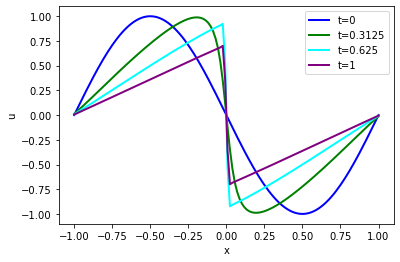

In [14]:
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays
import pylab

fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue', label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan', label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); 
pylab.ylabel('u'); 
pylab.legend()

In [20]:
def show_state(a, title):
    a=np.expand_dims(a, axis=2)

    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)

    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    #print("Resulting image size" +format(a.shape))

    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)
    vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 )
    # save for comparison with reconstructions later on

vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 )

import os; 
os.makedirs("./temp",exist_ok=True) 
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,STEPS+1]))

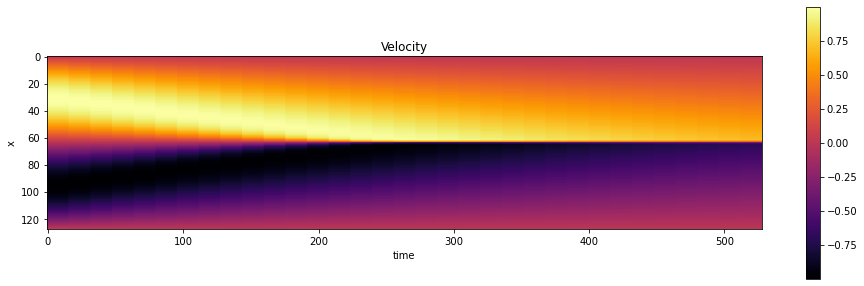

In [21]:
show_state(vels_img, "Velocity")